# E-Commerce Customer Behaviour Analysis

This notebook simulates a realistic **e-commerce customer dataset** and performs end-to-end exploratory data analysis (EDA), covering distribution fitting, statistical testing, and time-series revenue analysis.

### What this notebook covers
- Simulating 10,000 customer records using real-world statistical distributions
- EDA on order values: histograms, Q-Q plots, ECDF, and Box-Cox transformation
- Distribution fitting and goodness-of-fit testing
- Time-series revenue resampling and 7-day rolling average smoothing
- Hospital patient arrival simulation using Poisson processes

In [ ]:
pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14299 sha256=a8107599be2f6f138776782ae14943e5c4390631924db934224f31bad80ef8c3
  Stored in directory: /root/.cache/pip/wheels/26/56/da/ea90b6b66dc5e72379a64e2819815066873f00c1350126e876
Successfully built empiricaldist


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gamma, expon, poisson, lognorm, norm
from empiricaldist import Cdf

## 1. Simulate Customer Dataset

Each feature is drawn from a distribution chosen to match realistic e-commerce behaviour:

| Feature | Distribution | Rationale |
|---|---|---|
| `order_value` | Gamma(α=2, scale=100) | Right-skewed spend amounts |
| `time_on_site` | LogNormal(μ=ln(7), σ=0.5) | Session times are log-normally distributed |
| `items_in_cart` | Poisson(λ=3) | Discrete count data |
| `pages_visited` | Uniform(2, 15) | Random browsing depth |

In [ ]:
n = 10_000

customer_data = pd.DataFrame({
    'customer_id':   np.arange(1, n + 1),
    'order_value':   stats.gamma.rvs(a=2, scale=100, size=n),
    'time_on_site':  stats.lognorm.rvs(s=0.5, scale=np.exp(2), size=n),
    'items_in_cart': stats.poisson.rvs(mu=3, size=n),
    'pages_visited': stats.randint.rvs(low=2, high=15, size=n),
})

# Simulate visit timestamps over 6 months
timestamp_pool = pd.date_range(start='2024-01-01', end='2024-06-30', freq='5min')
customer_data['visit_time'] = np.random.choice(timestamp_pool, size=n)

customer_data['device_type'] = np.random.choice(
    ['Mobile', 'Desktop', 'Tablet'], size=n, p=[0.6, 0.3, 0.1]
)
customer_data['region'] = np.random.choice(
    ['North', 'South', 'East', 'West'], size=n
)

print(f"Dataset shape: {customer_data.shape}")
customer_data.head()

Dataset shape: (10000, 8)


,customer_id,order_value,time_on_site,items_in_cart,pages_visited,visit_time,device_type,region
0,1,530.536015,5.539699,3,14,2024-02-27 00:45:00,Mobile,West
1,2,183.886746,4.052079,4,11,2024-05-14 23:05:00,Desktop,East
2,3,52.307185,5.404866,2,10,2024-01-29 02:45:00,Tablet,East
3,4,215.488512,17.380608,3,13,2024-03-07 22:10:00,Desktop,East
4,5,195.046903,3.702599,4,2,2024-01-23 18:10:00,Mobile,North


In [ ]:
customer_data.describe().round(2)

,customer_id,order_value,time_on_site,items_in_cart,pages_visited,visit_time
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000
mean,5000.50,200.53,8.48,3.02,8.02,2024-03-30 16:50:03.900000
min,1.00,0.67,1.04,0.00,2.00,2024-01-01 00:10:00
25%,2500.75,96.36,5.31,2.00,5.00,2024-02-14 23:47:30
50%,5000.50,167.65,7.50,3.00,8.00,2024-03-30 01:07:30
75%,7500.25,268.42,10.53,4.00,11.00,2024-05-14 11:22:30
max,10000.00,1093.23,45.51,12.00,14.00,2024-06-30 00:00:00
std,2886.90,142.54,4.56,1.74,3.75,NaN


## 2. Order Value Analysis

We examine the distribution of order values using:
1. A histogram with a mean reference line
2. A Q-Q plot against the theoretical Gamma distribution
3. A Q-Q plot after Box-Cox transformation (to check normality)
4. An ECDF for non-parametric distribution inspection

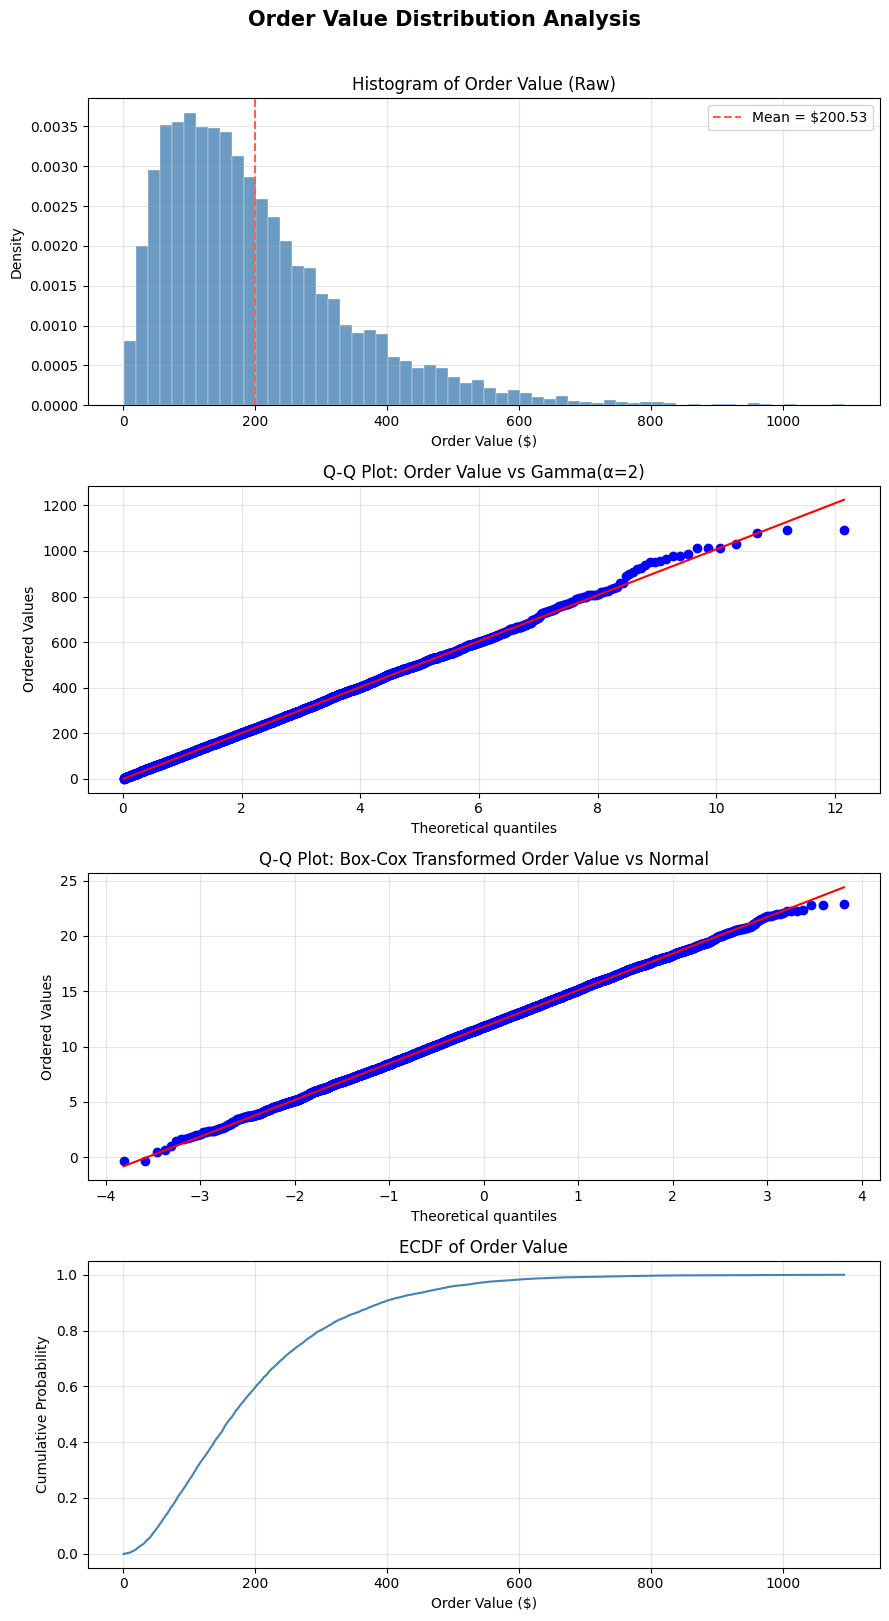

In [ ]:
order_values = customer_data['order_value']
transformed_values, _ = stats.boxcox(order_values)

fig, axs = plt.subplots(4, 1, figsize=(9, 16))
fig.suptitle('Order Value Distribution Analysis', fontsize=15, fontweight='bold', y=1.01)

# 1. Histogram
axs[0].hist(order_values, bins=60, density=True, color='steelblue', alpha=0.8, edgecolor='white', linewidth=0.3)
axs[0].axvline(order_values.mean(), color='tomato', linestyle='--', linewidth=1.5, label=f'Mean = ${order_values.mean():.2f}')
axs[0].set_title('Histogram of Order Value (Raw)')
axs[0].set_xlabel('Order Value ($)')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(alpha=0.3)

# 2. Q-Q plot vs Gamma
stats.probplot(order_values, dist='gamma', sparams=(2,), plot=axs[1])
axs[1].set_title('Q-Q Plot: Order Value vs Gamma(α=2)')
axs[1].grid(alpha=0.3)

# 3. Q-Q plot of Box-Cox transformed values vs Normal
stats.probplot(transformed_values, dist='norm', plot=axs[2])
axs[2].set_title('Q-Q Plot: Box-Cox Transformed Order Value vs Normal')
axs[2].grid(alpha=0.3)

# 4. ECDF
cdf = Cdf.from_seq(order_values)
axs[3].plot(cdf, color='steelblue', linewidth=1.5)
axs[3].set_title('ECDF of Order Value')
axs[3].set_xlabel('Order Value ($)')
axs[3].set_ylabel('Cumulative Probability')
axs[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Time-on-Site: Distribution Fitting

We fit an exponential distribution to simulated session time data and overlay the estimated vs. theoretical PDFs to validate the fit.

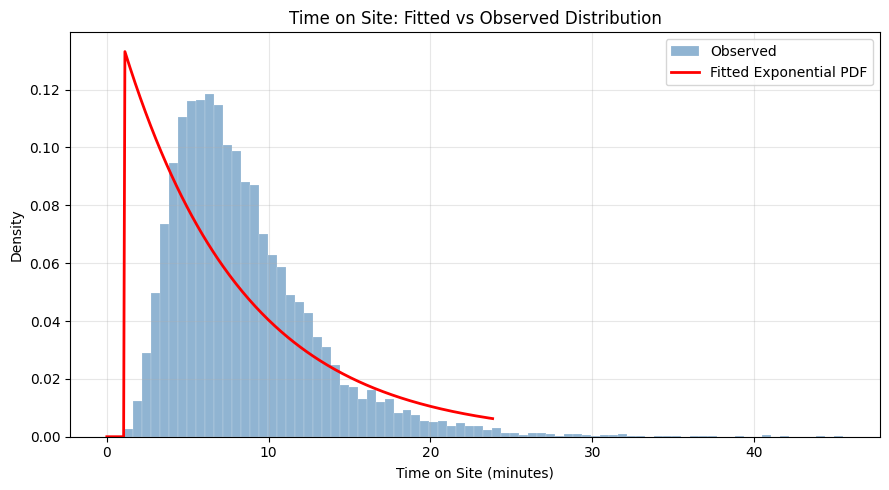

Estimated scale (mean session time): 7.44 minutes


In [ ]:
time_data = customer_data['time_on_site']
loc_est, scale_est = expon.fit(time_data)

x = np.linspace(0, time_data.quantile(0.99), 300)

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(time_data, bins=80, density=True, color='steelblue', alpha=0.6, edgecolor='white', linewidth=0.2, label='Observed')
ax.plot(x, expon.pdf(x, loc=loc_est, scale=scale_est), 'r-', linewidth=2, label='Fitted Exponential PDF')
ax.set_title('Time on Site: Fitted vs Observed Distribution')
ax.set_xlabel('Time on Site (minutes)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Estimated scale (mean session time): {scale_est:.2f} minutes")

## 4. Time-Series Revenue Analysis

We resample customer transactions by day to compute daily revenue, then apply a 7-day rolling average to smooth out short-term noise.

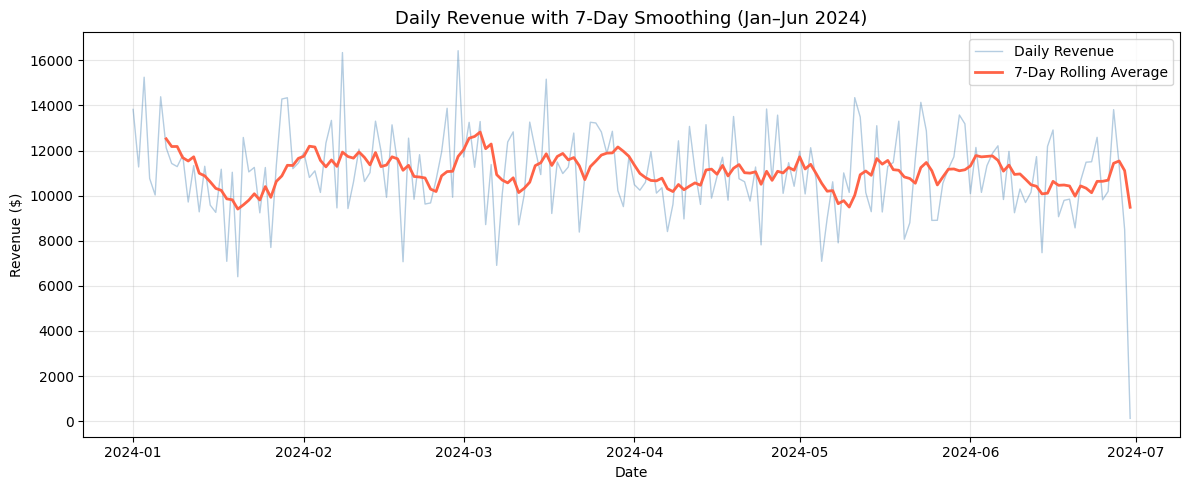

Average daily revenue: $11,018.15
Peak daily revenue:    $16,425.29


In [ ]:
ts_data = customer_data.set_index('visit_time').copy()
daily_revenue = ts_data.resample('D')['order_value'].sum()
rolling_avg = daily_revenue.rolling(window=7).mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(daily_revenue, alpha=0.4, color='steelblue', linewidth=1, label='Daily Revenue')
ax.plot(rolling_avg, color='tomato', linewidth=2, label='7-Day Rolling Average')
ax.set_title('Daily Revenue with 7-Day Smoothing (Jan–Jun 2024)', fontsize=13)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average daily revenue: ${daily_revenue.mean():,.2f}")
print(f"Peak daily revenue:    ${daily_revenue.max():,.2f}")

## 5. Hospital Arrival Simulation (Poisson Process)

A Poisson process models the number of random events in a fixed interval. Here we simulate hourly patient arrivals and visualise the overcrowding probability — a classic operations research problem.

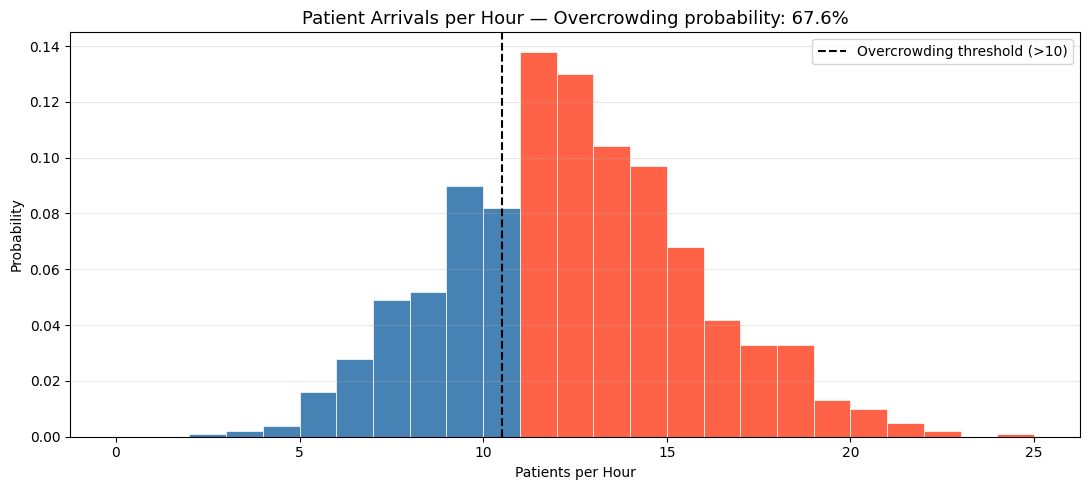

In [ ]:
LAMBDA = 12        # Average arrivals per hour
THRESHOLD = 10     # Overcrowding threshold

arrivals = poisson(mu=LAMBDA).rvs(1000)
overcrowding_prob = (arrivals > THRESHOLD).mean()

bins = np.arange(0, arrivals.max() + 2)
counts, _ = np.histogram(arrivals, bins=bins)
probs = counts / counts.sum()
bar_colors = ['tomato' if x > THRESHOLD else 'steelblue' for x in bins[:-1]]

fig, ax = plt.subplots(figsize=(11, 5))
ax.bar(bins[:-1], probs, width=1, edgecolor='white', color=bar_colors, align='edge', linewidth=0.5)
ax.axvline(THRESHOLD + 0.5, color='black', linestyle='--', linewidth=1.5, label=f'Overcrowding threshold (>{THRESHOLD})')
ax.set_title(f'Patient Arrivals per Hour — Overcrowding probability: {overcrowding_prob:.1%}', fontsize=13)
ax.set_xlabel('Patients per Hour')
ax.set_ylabel('Probability')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()